In [1]:
#MoveNET
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import cv2
import csv

2024-07-05 15:03:42.010961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


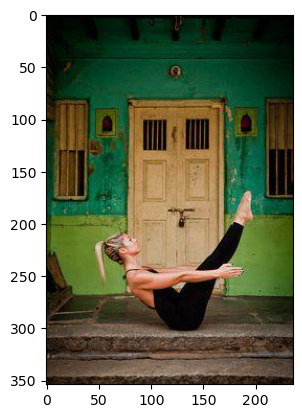

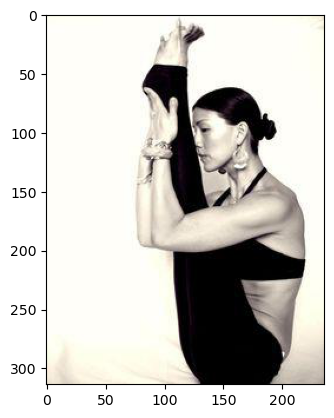

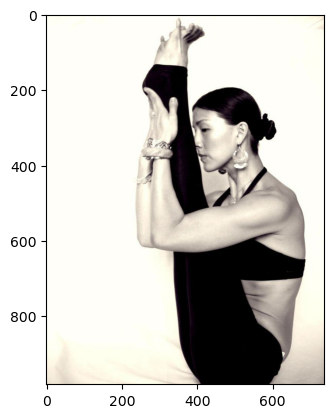

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Load the keypoints data
keypoints_path = '../data/keypoints/Boat.csv'
keypoints_df = pd.read_csv(keypoints_path)

# Extract the keypoints for the first three images
keypoints_first_three = keypoints_df.iloc[:3]

# Define the correct image paths (adjust these paths as necessary)
image_folder = '../data/images/Boat/'
image_files = [
    'Boat_Pose_01.jpeg',
    'Boat_Pose_02.jpeg',
    'Boat_Pose_03.jpeg'
]

image_paths = [os.path.join(image_folder, image_file) for image_file in image_files]

# Check if images exist
for path in image_paths:
    if not os.path.exists(path):
        print(f"Image not found: {path}")

# Define a function to plot keypoints on an image
def plot_keypoints(image, keypoints):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        if conf > 0.5:  # Only plot keypoints with a high confidence score
            plt.scatter(x * image.shape[1], y * image.shape[0], s=20, c='r', marker='o')
    plt.show()

# Load and display the images with keypoints
for i, image_path in enumerate(image_paths):
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        keypoints = keypoints_first_three.iloc[i].values[1:]  # Exclude the 'Class' column
        plot_keypoints(image, keypoints)
    else:
        print(f"Skipping {image_path} as it does not exist.")


In [5]:


# Load MoveNet Thunder model from TensorFlow Hub
model_url = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
movenet = hub.load(model_url)

print("MoveNet model loaded successfully.")

2024-07-05 15:14:04.104683: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


KeyboardInterrupt: 

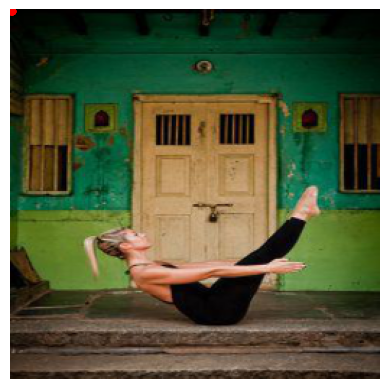

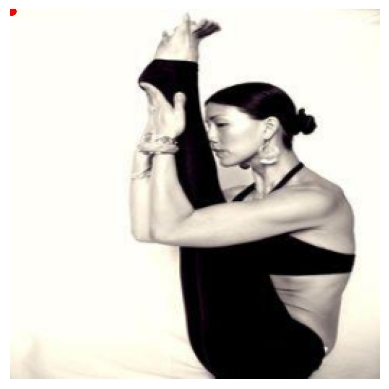

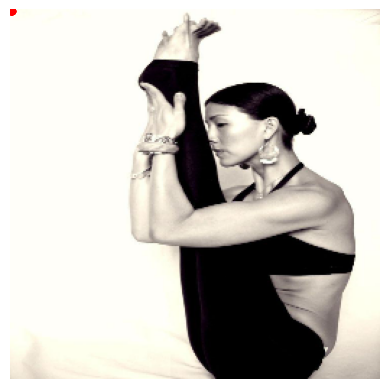

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Load the keypoints data
keypoints_path = '../data/keypoints/Boat.csv'
keypoints_df = pd.read_csv(keypoints_path)

# Extract the keypoints for the first three images
keypoints_first_three = keypoints_df.iloc[:3]

# Define the correct image paths
image_folder = '../data/images/Boat/'
image_files = [
    'Boat_Pose_01.jpeg',
    'Boat_Pose_02.jpeg',
    'Boat_Pose_03.jpeg'
]

image_paths = [os.path.join(image_folder, image_file) for image_file in image_files]

# Check if images exist
for path in image_paths:
    if not os.path.exists(path):
        print(f"Image not found: {path}")

# Define a function to plot keypoints on an image
def plot_keypoints(image, keypoints):
    # Resize image to MoveNet's expected input size (256x256 pixels)
    resized_image = cv2.resize(image, (256, 256))
    
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        if conf > 0:  # Only plot keypoints with a high confidence score
            plt.scatter(x, y, s=20, c='r', marker='o')  # Plot keypoints as red dots
    plt.axis('off')
    plt.show()

# Load and display the images with keypoints
for i, image_path in enumerate(image_paths):
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        keypoints = keypoints_first_three.iloc[i].values[1:]  # Exclude the 'Class' column
        keypoints = keypoints.astype(float)  # Ensure keypoints are float for plotting
        plot_keypoints(image, keypoints)
    else:
        print(f"Skipping {image_path} as it does not exist.")


In [3]:
def load_and_preprocess_image(image_path):
    # Read the image from file
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    
    # Resize image to 256x256
    image = cv2.resize(image, (256, 256))
    
    # Normalize image to [0, 1]
    image = image / 255.0
    
    # Add batch dimension
    image = np.expand_dims(image, axis=0).astype(np.float32)
    
    return image

In [4]:
# Function to detect keypoints
def detect_keypoints(image):
    # Convert image to tf.int32
    image = tf.cast(image, tf.int32)
    # Run model inference
    outputs = movenet.signatures['serving_default'](tf.constant(image))
    keypoints = outputs['output_0'].numpy().reshape(-1, 3)
    
    return keypoints

In [5]:
# Function to save keypoints with class name to CSV
def save_keypoints_with_class(keypoints, class_name, csv_path, headers):
    # Prepare the data row
    row = [class_name] + keypoints.flatten().tolist()
    
    # Check if the CSV file exists
    file_exists = os.path.isfile(csv_path)
    
    # Write to the CSV file
    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(headers)  # Write the headers if file doesn't exist
        writer.writerow(row)

In [7]:
# Define the base directories
images_base_dir = '../data/images'
keypoints_base_dir = '../data/keypoints'
os.makedirs(keypoints_base_dir, exist_ok=True)

# Define headers for the CSV file
headers = ["Class",
           "Nose_x", "Nose_y", "Nose_conf",
           "LeftEye_x", "LeftEye_y", "LeftEye_conf",
           "RightEye_x", "RightEye_y", "RightEye_conf",
           "LeftEar_x", "LeftEar_y", "LeftEar_conf",
           "RightEar_x", "RightEar_y", "RightEar_conf",
           "LeftShoulder_x", "LeftShoulder_y", "LeftShoulder_conf",
           "RightShoulder_x", "RightShoulder_y", "RightShoulder_conf",
           "LeftElbow_x", "LeftElbow_y", "LeftElbow_conf",
           "RightElbow_x", "RightElbow_y", "RightElbow_conf",
           "LeftWrist_x", "LeftWrist_y", "LeftWrist_conf",
           "RightWrist_x", "RightWrist_y", "RightWrist_conf",
           "LeftHip_x", "LeftHip_y", "LeftHip_conf",
           "RightHip_x", "RightHip_y", "RightHip_conf",
           "LeftKnee_x", "LeftKnee_y", "LeftKnee_conf",
           "RightKnee_x", "RightKnee_y", "RightKnee_conf",
           "LeftAnkle_x", "LeftAnkle_y", "LeftAnkle_conf",
           "RightAnkle_x", "RightAnkle_y", "RightAnkle_conf"]
# Function to process all images and extract keypoints
def process_images_and_extract_keypoints():
    for class_folder in os.listdir(images_base_dir):
        class_folder_path = os.path.join(images_base_dir, class_folder)
        if os.path.isdir(class_folder_path):
            class_name = class_folder
            for file in os.listdir(class_folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_folder_path, file)
                    keypoints_path = os.path.join(keypoints_base_dir, class_name + '.csv')
                    os.makedirs(os.path.dirname(keypoints_path), exist_ok=True)

                    try:
                        # Load and preprocess image
                        image = load_and_preprocess_image(image_path)
                        # Extract keypoints
                        keypoints = detect_keypoints(image)
                        # Save keypoints with class name to a file
                        save_keypoints_with_class(keypoints, class_name, keypoints_path, headers)
                        print(f"Processed {image_path}, saved keypoints to {keypoints_path}")
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")

# Process all images
process_images_and_extract_keypoints()

Processed ../data/images/Upward_Facing_Two-Foot_Staff/Upward_Facing_Two-Foot_Staff_Pose_03.jpeg, saved keypoints to ../data/keypoints/Upward_Facing_Two-Foot_Staff.csv
Processed ../data/images/Upward_Facing_Two-Foot_Staff/Upward_Facing_Two-Foot_Staff_Pose_39.png, saved keypoints to ../data/keypoints/Upward_Facing_Two-Foot_Staff.csv
Processed ../data/images/Upward_Facing_Two-Foot_Staff/Upward_Facing_Two-Foot_Staff_Pose_82.jpeg, saved keypoints to ../data/keypoints/Upward_Facing_Two-Foot_Staff.csv
Processed ../data/images/Upward_Facing_Two-Foot_Staff/Upward_Facing_Two-Foot_Staff_Pose_32.jpeg, saved keypoints to ../data/keypoints/Upward_Facing_Two-Foot_Staff.csv
Processed ../data/images/Upward_Facing_Two-Foot_Staff/Upward_Facing_Two-Foot_Staff_Pose_22.png, saved keypoints to ../data/keypoints/Upward_Facing_Two-Foot_Staff.csv
Processed ../data/images/Upward_Facing_Two-Foot_Staff/Upward_Facing_Two-Foot_Staff_Pose_56.jpeg, saved keypoints to ../data/keypoints/Upward_Facing_Two-Foot_Staff.csv


libpng warning: iCCP: known incorrect sRGB profile


Processed ../data/images/Peacock/Peacock_Pose_13.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_01.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_114.jpeg, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_80.jpeg, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_59.jpeg, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_42.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_30.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_58.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_82.jpeg, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_08.png, saved keypoint

libpng warning: iCCP: known incorrect sRGB profile


Processed ../data/images/Peacock/Peacock_Pose_43.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_09.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_37.jpeg, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_77.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_65.jpeg, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_17.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_12.jpeg, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_18.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_66.png, saved keypoints to ../data/keypoints/Peacock.csv
Processed ../data/images/Peacock/Peacock_Pose_41.jpeg, saved keypoints

libpng warning: iCCP: known incorrect sRGB profile


Processed ../data/images/Extended_Revolved_Side_Angle/Extended_Revolved_Side_Angle_Pose_237.png, saved keypoints to ../data/keypoints/Extended_Revolved_Side_Angle.csv
Processed ../data/images/Extended_Revolved_Side_Angle/Extended_Revolved_Side_Angle_Pose_251.jpeg, saved keypoints to ../data/keypoints/Extended_Revolved_Side_Angle.csv
Processed ../data/images/Extended_Revolved_Side_Angle/Extended_Revolved_Side_Angle_Pose_231.png, saved keypoints to ../data/keypoints/Extended_Revolved_Side_Angle.csv
Processed ../data/images/Extended_Revolved_Side_Angle/Extended_Revolved_Side_Angle_Pose_277.jpeg, saved keypoints to ../data/keypoints/Extended_Revolved_Side_Angle.csv
Processed ../data/images/Extended_Revolved_Side_Angle/Extended_Revolved_Side_Angle_Pose_180.jpeg, saved keypoints to ../data/keypoints/Extended_Revolved_Side_Angle.csv
Processed ../data/images/Extended_Revolved_Side_Angle/Extended_Revolved_Side_Angle_Pose_162.jpeg, saved keypoints to ../data/keypoints/Extended_Revolved_Side_Angl

libpng warning: iCCP: known incorrect sRGB profile


Processed ../data/images/Locust/Locust_Pose_50.png, saved keypoints to ../data/keypoints/Locust.csv
Processed ../data/images/Locust/Locust_Pose_112.jpeg, saved keypoints to ../data/keypoints/Locust.csv
Processed ../data/images/Locust/Locust_Pose_22.jpeg, saved keypoints to ../data/keypoints/Locust.csv
Processed ../data/images/Locust/Locust_Pose_97.jpeg, saved keypoints to ../data/keypoints/Locust.csv
Processed ../data/images/Locust/Locust_Pose_74.jpeg, saved keypoints to ../data/keypoints/Locust.csv
Processed ../data/images/Handstand_pose/Handstand_pose_98.jpeg, saved keypoints to ../data/keypoints/Handstand_pose.csv
Processed ../data/images/Handstand_pose/Handstand_pose_114.jpeg, saved keypoints to ../data/keypoints/Handstand_pose.csv
Processed ../data/images/Handstand_pose/Handstand_pose_113.jpeg, saved keypoints to ../data/keypoints/Handstand_pose.csv
Processed ../data/images/Handstand_pose/Handstand_pose_126.jpeg, saved keypoints to ../data/keypoints/Handstand_pose.csv
Processed ..

libpng warning: iCCP: known incorrect sRGB profile


Processed ../data/images/Reclining_Bound_Angle/Reclining_Bound_Angle_Pose_51.png, saved keypoints to ../data/keypoints/Reclining_Bound_Angle.csv
Processed ../data/images/Reclining_Bound_Angle/Reclining_Bound_Angle_Pose_22.jpeg, saved keypoints to ../data/keypoints/Reclining_Bound_Angle.csv
Processed ../data/images/Reclining_Bound_Angle/Reclining_Bound_Angle_Pose_70.jpeg, saved keypoints to ../data/keypoints/Reclining_Bound_Angle.csv
Processed ../data/images/Reclining_Bound_Angle/Reclining_Bound_Angle_Pose_185.jpeg, saved keypoints to ../data/keypoints/Reclining_Bound_Angle.csv
Processed ../data/images/Reclining_Bound_Angle/Reclining_Bound_Angle_Pose_161.jpeg, saved keypoints to ../data/keypoints/Reclining_Bound_Angle.csv
Processed ../data/images/Reclining_Bound_Angle/Reclining_Bound_Angle_Pose_169.jpeg, saved keypoints to ../data/keypoints/Reclining_Bound_Angle.csv
Processed ../data/images/Reclining_Bound_Angle/Reclining_Bound_Angle_Pose_21.jpeg, saved keypoints to ../data/keypoints/Re

libpng warning: iCCP: known incorrect sRGB profile


Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_Pose_58.png, saved keypoints to ../data/keypoints/One_Legged_Pigeon.csv
Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_Pose_74.jpeg, saved keypoints to ../data/keypoints/One_Legged_Pigeon.csv
Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_Pose_24.jpeg, saved keypoints to ../data/keypoints/One_Legged_Pigeon.csv
Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_Pose_157.jpeg, saved keypoints to ../data/keypoints/One_Legged_Pigeon.csv
Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_Pose_29.jpeg, saved keypoints to ../data/keypoints/One_Legged_Pigeon.csv
Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_Pose_88.jpeg, saved keypoints to ../data/keypoints/One_Legged_Pigeon.csv
Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_Pose_54.jpeg, saved keypoints to ../data/keypoints/One_Legged_Pigeon.csv
Processed ../data/images/One_Legged_Pigeon/One_Legged_Pigeon_P

libpng warning: iCCP: known incorrect sRGB profile


Processed ../data/images/Downward-Facing_Dog/Downward-Facing_Dog_pose_97.png, saved keypoints to ../data/keypoints/Downward-Facing_Dog.csv
Processed ../data/images/Downward-Facing_Dog/Downward-Facing_Dog_pose_126.jpeg, saved keypoints to ../data/keypoints/Downward-Facing_Dog.csv
Processed ../data/images/Downward-Facing_Dog/Downward-Facing_Dog_pose_149.jpeg, saved keypoints to ../data/keypoints/Downward-Facing_Dog.csv
Processed ../data/images/Downward-Facing_Dog/Downward-Facing_Dog_pose_12.jpeg, saved keypoints to ../data/keypoints/Downward-Facing_Dog.csv
Processed ../data/images/Downward-Facing_Dog/Downward-Facing_Dog_pose_100.jpeg, saved keypoints to ../data/keypoints/Downward-Facing_Dog.csv
Processed ../data/images/Downward-Facing_Dog/Downward-Facing_Dog_pose_24.jpeg, saved keypoints to ../data/keypoints/Downward-Facing_Dog.csv
Processed ../data/images/Downward-Facing_Dog/Downward-Facing_Dog_pose_06.jpeg, saved keypoints to ../data/keypoints/Downward-Facing_Dog.csv
Processed ../data/

Combined keypoints data saved to combined_keypoints.csv


In [2]:
#LSTM MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [3]:
keypoints_base_dir = '../data/keypoints'
combined_csv_path = os.path.join(keypoints_base_dir, 'combined_keypoints.csv')

def combine_csv_files(base_dir, output_path):
    combined_df = pd.DataFrame()
    for file in os.listdir(base_dir):
        if file.endswith('.csv'):
            class_name = file.replace('.csv', '')
            file_path = os.path.join(base_dir, file)
            df = pd.read_csv(file_path)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    combined_df.to_csv(output_path, index=False)
    return combined_df

combined_df = combine_csv_files(keypoints_base_dir, combined_csv_path)
print(f"Combined CSV saved to {combined_csv_path}")

Combined CSV saved to ../data/keypoints/combined_keypoints.csv


In [4]:
def load_combined_keypoints_data(file_path):
    df = pd.read_csv(file_path)
    labels = df['Class'].values
    data = df.drop(columns=['Class']).values
    return data, labels

keypoints_data, labels = load_combined_keypoints_data(combined_csv_path)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(keypoints_data, encoded_labels, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [5]:

def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(encoded_labels))

model = build_lstm_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-07-04 00:18:08.018729: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-07-04 00:18:09.667499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-04 00:18:09.674187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-04 00:18:09.6

In [6]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10


2024-07-04 00:18:21.124358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-04 00:18:21.127752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-04 00:18:21.130573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1648/1648 [==============================] - ETA: 0s - loss: 4.3477 - accuracy: 0.0332

2024-07-04 00:19:09.690564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-04 00:19:09.693793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-04 00:19:09.696547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1648/1648 [==============================] - 54s 27ms/step - loss: 4.3477 - accuracy: 0.0332 - val_loss: 4.3372 - val_accuracy: 0.0290
Epoch 2/10
1648/1648 [==============================] - 43s 26ms/step - loss: 4.3230 - accuracy: 0.0319 - val_loss: 4.3102 - val_accuracy: 0.0323
Epoch 3/10
1648/1648 [==============================] - 41s 25ms/step - loss: 4.3047 - accuracy: 0.0321 - val_loss: 4.3063 - val_accuracy: 0.0322
Epoch 4/10
1648/1648 [==============================] - 49s 30ms/step - loss: 4.2897 - accuracy: 0.0307 - val_loss: 4.2819 - val_accuracy: 0.0320
Epoch 5/10
1648/1648 [==============================] - 41s 25ms/step - loss: 4.2759 - accuracy: 0.0300 - val_loss: 4.2725 - val_accuracy: 0.0293
Epoch 6/10
1648/1648 [==============================] - 45s 27ms/step - loss: 4.2636 - accuracy: 0.0299 - val_loss: 4.2743 - val_accuracy: 0.0284
Epoch 7/10
1648/1648 [==============================] - 46s 28ms/step - loss: 4.2483 - accuracy: 0.0291 - val_loss: 4.2528 - val_accura

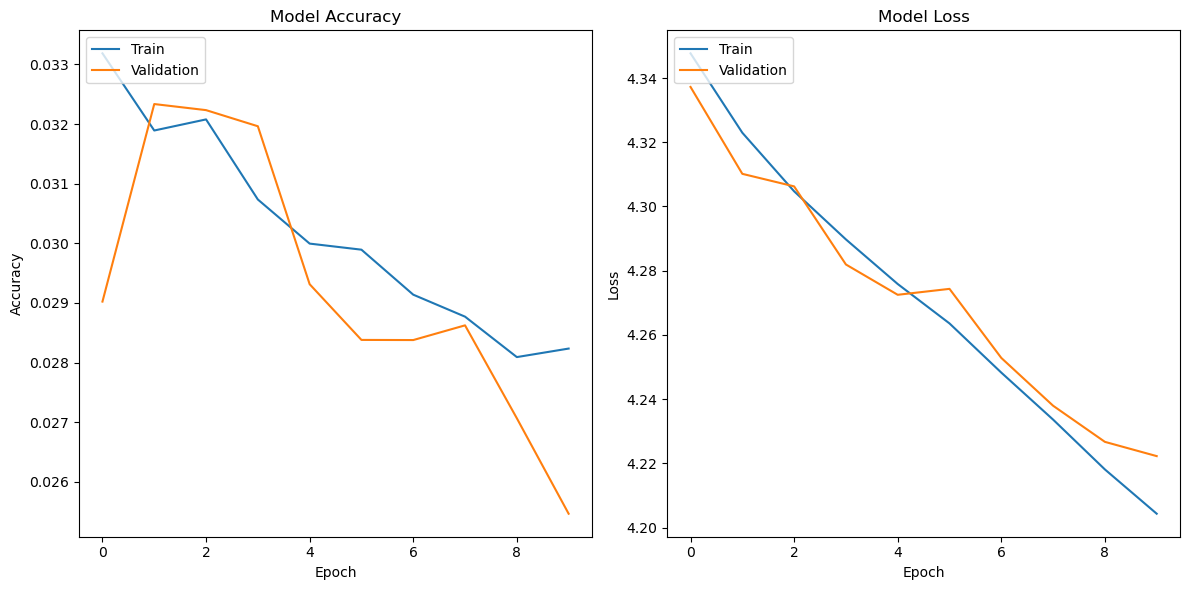

In [7]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot training history
plot_training_history(history)

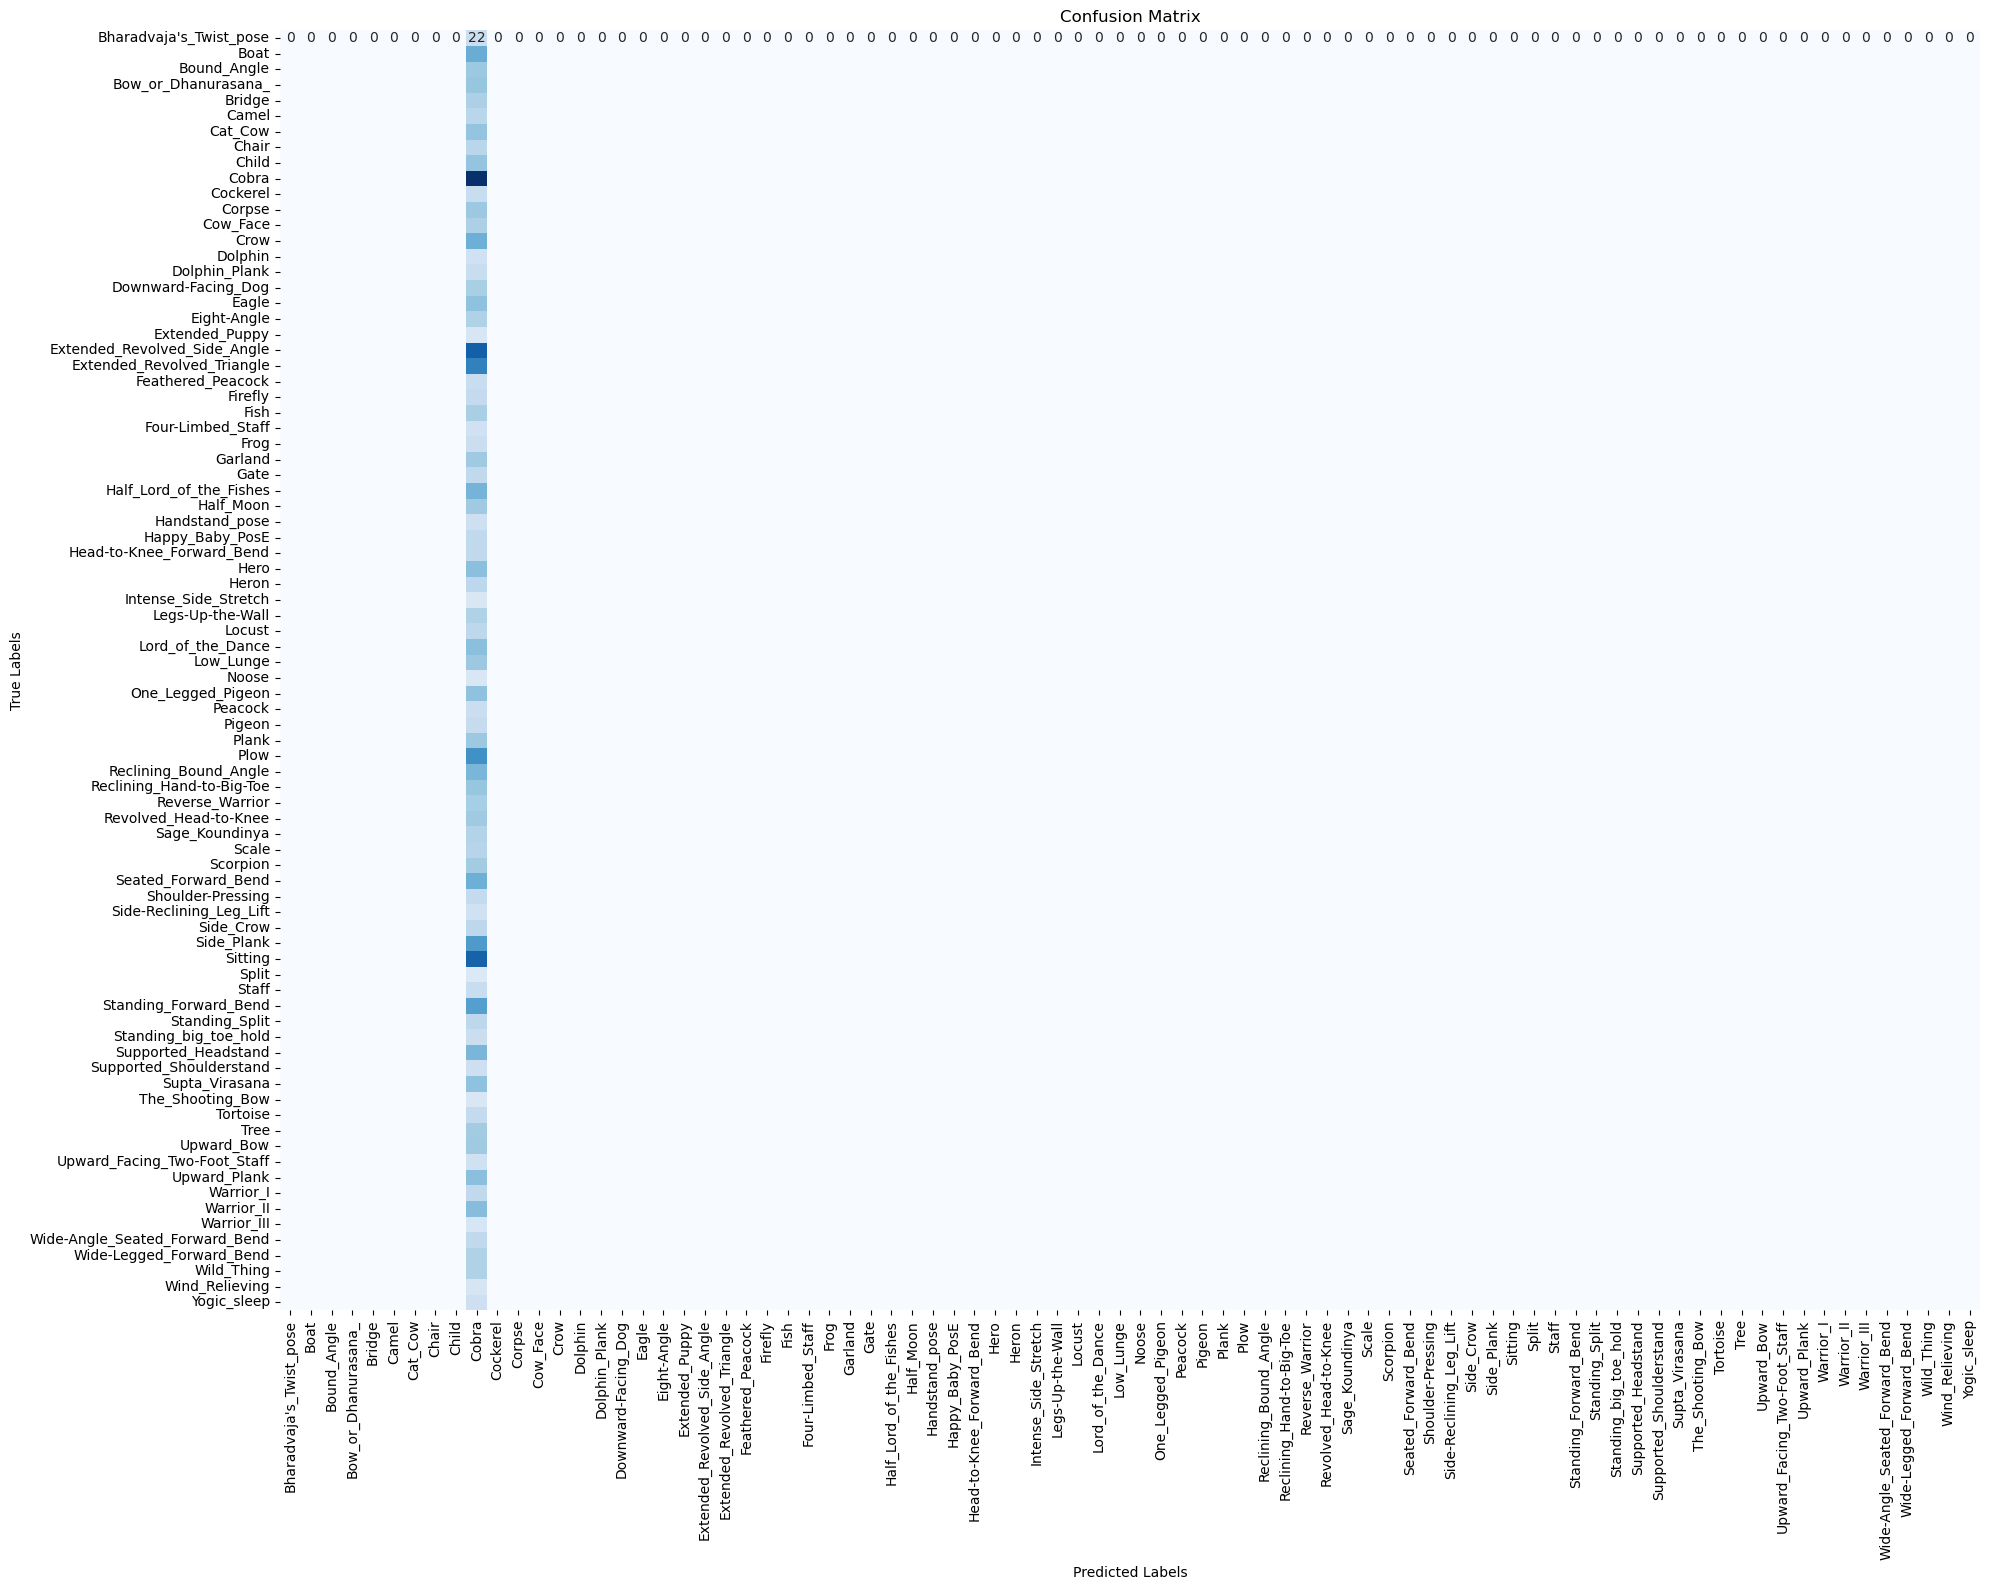

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar=False)  # Optionally, you can turn off the color bar if not needed
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if needed
plt.yticks(rotation=0)   # Rotate y-axis labels if needed
plt.tight_layout()
plt.show()

In [33]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

86/86 [==============================] - 2s 17ms/step
Test Accuracy: 3.53%
Classification Report:
                                precision    recall  f1-score   support

       Bharadvaja's_Twist_pose       0.00      0.00      0.00        22
                          Boat       0.00      0.00      0.00        49
                   Bound_Angle       0.00      0.00      0.00        37
           Bow_or_Dhanurasana_       0.00      0.00      0.00        38
                        Bridge       0.00      0.00      0.00        32
                         Camel       0.00      0.00      0.00        28
                       Cat_Cow       0.00      0.00      0.00        39
                         Chair       0.00      0.00      0.00        28
                         Child       0.00      0.00      0.00        39
                         Cobra       0.04      1.00      0.07        97
                      Cockerel       0.00      0.00      0.00        23
                        Corpse       

/home/abdulah/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abdulah/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abdulah/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Reverse transform encoded labels back to original class labels
predicted_classes = label_encoder.inverse_transform(y_pred_classes)

# Display some predictions
for i in range(100):  # Displaying first 10 predictions
    print(f"Predicted: {predicted_classes[i]}, Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")

Predicted: Cobra, Actual: Downward-Facing_Dog
Predicted: Cobra, Actual: Happy_Baby_PosE
Predicted: Cobra, Actual: Heron
Predicted: Cobra, Actual: Eagle
Predicted: Cobra, Actual: Lord_of_the_Dance
Predicted: Cobra, Actual: Supported_Headstand
Predicted: Cobra, Actual: Tortoise
Predicted: Cobra, Actual: Sage_Koundinya
Predicted: Cobra, Actual: Bridge
Predicted: Cobra, Actual: Gate
Predicted: Cobra, Actual: Intense_Side_Stretch
Predicted: Cobra, Actual: Crow
Predicted: Cobra, Actual: Four-Limbed_Staff
Predicted: Cobra, Actual: Reverse_Warrior
Predicted: Cobra, Actual: Warrior_II
Predicted: Cobra, Actual: Eagle
Predicted: Cobra, Actual: Plow
Predicted: Cobra, Actual: Shoulder-Pressing
Predicted: Cobra, Actual: Seated_Forward_Bend
Predicted: Cobra, Actual: Supta_Virasana
Predicted: Cobra, Actual: Wide-Legged_Forward_Bend
Predicted: Cobra, Actual: Cobra
Predicted: Cobra, Actual: Supported_Headstand
Predicted: Cobra, Actual: Lord_of_the_Dance
Predicted: Cobra, Actual: Reverse_Warrior
Predicte

In [20]:
model.save('yoga_pose_classifier.h5')
#end of LSTM Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Save the model for future use
model.save('yoga_pose_classifier.h5')

In [ ]:
#classifier_Random_Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest accuracy: {accuracy:.4f}')


In [ ]:
#Classifier_SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM accuracy: {accuracy:.4f}')


In [ ]:
#Classic_CNN